In [1]:
import warnings
warnings.filterwarnings('ignore', 'numpy.dtype size changed')
warnings.filterwarnings( 'ignore', category=FutureWarning)

from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy.calc as mpcalc
import metpy.constants as mpconstants
from metpy.units import units
import numpy as np
from pyproj import Proj
from scipy.ndimage import gaussian_filter
import xarray as xr

In [2]:
date = datetime(2019, 3, 13, 12)

ds = xr.open_dataset('https://www.ncdc.noaa.gov/thredds/dodsC/model-gfs-g4-anl-files-old/'
                     f'{date:%Y%m}/{date:%Y%m%d}/gfsanl_4_{date:%Y%m%d}_{date:%H}00_000.grb2')

#ds = xr.open_dataset('groundhogs_day_blizzard/GFS_{0:%Y%m%d}_{0:%H}00.nc'.format(date))

lats = ds.lat.sel(lat=slice(60, 10)).values
lons = ds.lon.sel(lon=slice(360-160, 360-50)).values

dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

subset = dict(vertical=500 * units.hPa, time=date, lat=slice(60, 10), lon=slice(360-160, 360-50))
hght_500 = ds['Geopotential_height_isobaric'].metpy.sel(subset).values
uwnd_500 = (ds['u-component_of_wind_isobaric'].metpy.sel(subset).values) * units('m/s')
vwnd_500 = (ds['v-component_of_wind_isobaric'].metpy.sel(subset).values) * units('m/s')
tmpk_500 = (ds['Temperature_isobaric'].metpy.sel(subset).values) * units.K

hght_500s = mpcalc.smooth_n_point(hght_500, 9, 80)
uwnd_500s = mpcalc.smooth_n_point(uwnd_500, 9, 80)
vwnd_500s = mpcalc.smooth_n_point(vwnd_500, 9, 80)
tmpk_500s = mpcalc.smooth_n_point(tmpk_500, 9, 80)

In [3]:
subset['vertical'] = 700 * units.hPa
tmpk_700 = (ds['Temperature_isobaric'].metpy.sel(subset).values) * units.K
uwnd_700 = (ds['u-component_of_wind_isobaric'].metpy.sel(subset).values) * units('m/s')
vwnd_700 = (ds['v-component_of_wind_isobaric'].metpy.sel(subset).values) * units('m/s')

tmpk_700s = mpcalc.smooth_n_point(tmpk_700, 9, 80)
uwnd_700s = mpcalc.smooth_n_point(uwnd_700, 9, 80)
vwnd_700s = mpcalc.smooth_n_point(vwnd_700, 9, 80)

In [4]:
subset['vertical'] = 300 * units.hPa
tmpk_300 = (ds['Temperature_isobaric'].metpy.sel(subset).values) * units.K
uwnd_300 = (ds['u-component_of_wind_isobaric'].metpy.sel(subset).values) * units('m/s')
vwnd_300 = (ds['v-component_of_wind_isobaric'].metpy.sel(subset).values) * units('m/s')

tmpk_300s = mpcalc.smooth_n_point(tmpk_300, 9, 80)
uwnd_300s = mpcalc.smooth_n_point(uwnd_300, 9, 80)
vwnd_300s = mpcalc.smooth_n_point(vwnd_300, 9, 80)

In [5]:
vtime = ds['Geopotential_height_isobaric'].time.values[0].astype('datetime64[ms]').astype('O')

mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35, standard_parallels=(30, 60))
datacrs = ccrs.PlateCarree()

# Transform Coordinates ahead of time
lons, lats = np.meshgrid(lons, lats)
tlatlons = mapcrs.transform_points(ccrs.PlateCarree(), lons, lats)
clons = tlatlons[:,:,0]
clats = tlatlons[:,:,1]

# QGHT Forcing Terms
sigma = 2.0e-6 * units('m^2 Pa^-2 s^-2')
f0 = 1e-4 * units('s^-1')
Rd = mpconstants.Rd

avor_500 = mpcalc.absolute_vorticity(uwnd_500s, vwnd_500s, dx, dy, lats * units('degrees'))
vortadv_500 = mpcalc.advection(avor_500, (uwnd_500s, vwnd_500s), (dx, dy)).to_base_units()

term_A = f0 * vortadv_500

tadv_700 = mpcalc.advection(tmpk_700s, (uwnd_700s, vwnd_700s), (dx, dy)).to_base_units()
tadv_300 = mpcalc.advection(tmpk_300s, (uwnd_300s, vwnd_300s), (dx, dy)).to_base_units()

diff_tadv = ((Rd/(700 * units.hPa)*tadv_700 - Rd/(300 * units.hPa)*tadv_300)/(400 * units.hPa)).to_base_units()

term_B = (-f0**2/sigma*diff_tadv).to_base_units()

# Q-Vectors and QVect Divergence
u_qvect, v_qvect = mpcalc.q_vector(uwnd_700s, vwnd_700s, tmpk_700s, 700*units.hPa, dx, dy)

Qdiv = mpcalc.divergence(u_qvect, v_qvect, dx, dy)

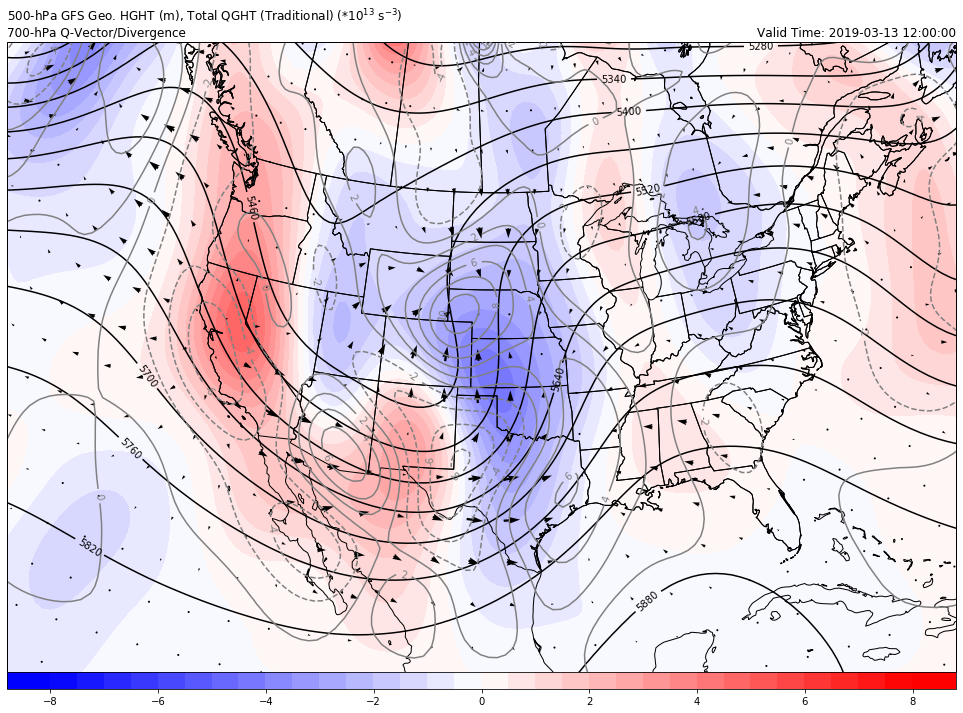

In [6]:
clevs_700_tmpc = np.arange(-40, 41, 2)
clevs_500_hght = np.arange(0, 8000, 60)
clevs_QGHT = np.arange(-8, 8.5, 0.5)

wind_slice = (slice(2, None, 5), slice(2, None, 5))

fig = plt.figure(1, figsize=(17,15))

# 3rd panel
ax3 = plt.subplot(111, projection=mapcrs)

ax3.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax3.add_feature(cfeature.STATES.with_scale('50m'))

cf = ax3.contourf(clons, clats, -(term_A+term_B)*1e13, clevs_QGHT, cmap=plt.cm.bwr, extend='both')
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, extendrect=True)

cs = ax3.contour(clons, clats, hght_500s, clevs_500_hght, colors='black')
plt.clabel(cs, fmt='%d')

cs2 = ax3.contour(clons, clats, -2*Qdiv*1e18, np.arange(-20,21,2), colors='grey')
plt.clabel(cs2, fmt='%d')

ax3.quiver(lons[wind_slice], lats[wind_slice],
           u_qvect[wind_slice].m, v_qvect[wind_slice].m, pivot='mid',
           scale=5e-11, scale_units='height', transform=ccrs.PlateCarree())

plt.title('500-hPa GFS Geo. HGHT (m), Total QGHT (Traditional) '
          '($*10^{13}$ s$^{-3}$) \n700-hPa Q-Vector/Divergence', loc='left')
plt.title(f'Valid Time: {vtime}', loc='right')

#plt.savefig(f'QVector_Div_{date:%Y%m%d_%H}00.png')
plt.show()